In [1]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms

In [9]:
# Train Phase transformations
train_transforms = transforms.Compose([
                                      #  transforms.Resize((28, 28)),
                                      #  transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
                                      # transforms.RandomRotation((-7.0, 7.0), fill=(1,)),
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,)) # The mean and std have to be sequences (e.g., tuples), therefore you should add a comma after the values.
                                       # Note the difference between (0.1307) and (0.1307,)
                                       ])

# Test Phase transformations
test_transforms = transforms.Compose([
                                      #  transforms.Resize((28, 28)),
                                      #  transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,))
                                       ])


In [10]:
train = datasets.MNIST('./data', train=True, download=True, transform=train_transforms)
test = datasets.MNIST('./data', train=False, download=True, transform=test_transforms)

In [11]:
SEED = 1

# CUDA?
cuda = torch.cuda.is_available()
print("CUDA Available?", cuda)

# For reproducibility
torch.manual_seed(SEED)

if cuda:
    torch.cuda.manual_seed(SEED)

# dataloader arguments - something you'll fetch these from cmdprmt
dataloader_args = dict(shuffle=True, batch_size=156, num_workers=4, pin_memory=True) if cuda else dict(shuffle=True, batch_size=64)

# train dataloader
train_loader = torch.utils.data.DataLoader(train, **dataloader_args)

# test dataloader
test_loader = torch.utils.data.DataLoader(test, **dataloader_args)

CUDA Available? True


In [12]:
dropout_value = 0.05
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        # Input Block
        self.convblock1 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=8, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(8),
            nn.Dropout(dropout_value)
        ) # output_size = 26

        # CONVOLUTION BLOCK 1
        self.convblock2 = nn.Sequential(
            nn.Conv2d(in_channels=8, out_channels=8, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(8),
            nn.Dropout(dropout_value)
        ) # output_size = 24

        # TRANSITION BLOCK 1
        self.convblock3 = nn.Sequential(
            nn.Conv2d(in_channels=8, out_channels=8, kernel_size=(1, 1), padding=0, bias=False),
        ) # output_size = 24
        self.pool1 = nn.MaxPool2d(2, 2) # output_size = 12

        # CONVOLUTION BLOCK 2
        self.convblock4 = nn.Sequential(
            nn.Conv2d(in_channels=8, out_channels=14, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(14),
            nn.Dropout(dropout_value)
        ) # output_size = 10

        self.convblock5 = nn.Sequential(
            nn.Conv2d(in_channels=14, out_channels=14, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(14),
            nn.Dropout(dropout_value)
        ) # output_size = 8

        self.convblock6 = nn.Sequential(
            nn.Conv2d(in_channels=14, out_channels=14, kernel_size=(3, 3), padding=1, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(14),
            nn.Dropout(dropout_value)
        ) # output_size = 8

        self.convblock7 = nn.Sequential(
            nn.Conv2d(in_channels=14, out_channels=14, kernel_size=(3, 3), padding=1, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(14),
            nn.Dropout(dropout_value)
        ) # output_size = 8

        # OUTPUT BLOCK
        self.gap = nn.Sequential(
            nn.AvgPool2d(kernel_size=8)
        ) # output_size = 1

        self.convblock8 = nn.Sequential(
            nn.Conv2d(in_channels=14, out_channels=10, kernel_size=(1, 1), padding=0, bias=False),
            nn.BatchNorm2d(10),
            nn.ReLU()
        )

    def forward(self, x):
        x = self.convblock1(x)
        x = self.convblock2(x)
        x = self.convblock3(x)
        x = self.pool1(x)
        x = self.convblock4(x)
        x = self.convblock5(x)
        x = self.convblock6(x)
        x = self.convblock7(x)
        x = self.gap(x)
        x = self.convblock8(x)
        x = x.view(-1, 10)
        return F.log_softmax(x, dim=-1)

In [13]:
  !pip install torchsummary
from torchsummary import summary
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)
model = Net().to(device)
summary(model, input_size=(1, 28, 28))

cuda
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 8, 26, 26]              72
              ReLU-2            [-1, 8, 26, 26]               0
       BatchNorm2d-3            [-1, 8, 26, 26]              16
           Dropout-4            [-1, 8, 26, 26]               0
            Conv2d-5            [-1, 8, 24, 24]             576
              ReLU-6            [-1, 8, 24, 24]               0
       BatchNorm2d-7            [-1, 8, 24, 24]              16
           Dropout-8            [-1, 8, 24, 24]               0
            Conv2d-9            [-1, 8, 24, 24]              64
        MaxPool2d-10            [-1, 8, 12, 12]               0
           Conv2d-11           [-1, 14, 10, 10]           1,008
             ReLU-12           [-1, 14, 10, 10]               0
      BatchNorm2d-13           [-1, 14, 10, 10]              28
          Dropout-14           [-1

In [14]:
from tqdm import tqdm

train_losses = []
test_losses = []
train_acc = []
test_acc = []

def train(model, device, train_loader, optimizer, epoch):
  model.train()
  pbar = tqdm(train_loader)
  correct = 0
  processed = 0
  for batch_idx, (data, target) in enumerate(pbar):
    # get samples
    data, target = data.to(device), target.to(device)

    # Init
    optimizer.zero_grad()
    # In PyTorch, we need to set the gradients to zero before starting to do backpropragation because PyTorch accumulates the gradients on subsequent backward passes.
    # Because of this, when you start your training loop, ideally you should zero out the gradients so that you do the parameter update correctly.

    # Predict
    y_pred = model(data)

    # Calculate loss
    loss = F.nll_loss(y_pred, target)
    train_losses.append(loss)

    # Backpropagation
    loss.backward()
    optimizer.step()

    # Update pbar-tqdm

    pred = y_pred.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
    correct += pred.eq(target.view_as(pred)).sum().item()
    processed += len(data)

    pbar.set_description(desc= f'Loss={loss.item()} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')
    train_acc.append(100*correct/processed)

def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    test_losses.append(test_loss)

    test_accuracy = 100. * correct / len(test_loader.dataset)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        test_accuracy))

    test_acc.append(100. * correct / len(test_loader.dataset))
    return test_accuracy

In [15]:
from torch.optim.lr_scheduler import StepLR

model =  Net().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.02, momentum=0.9, weight_decay=1e-4)
scheduler = StepLR(optimizer, step_size=5, gamma=0.5)


EPOCHS = 15
best_acc = 0
for epoch in range(EPOCHS):
    print("\n======= EPOCH:", epoch)
    train(model, device, train_loader, optimizer, epoch)
    scheduler.step()
    test_accuracy = test(model, device, test_loader)

    if test_accuracy > best_acc:
        best_acc = test_accuracy
    print(f'>>> Best Test Accuracy: {best_acc:.2f}%')


======= EPOCH: 0


Loss=0.11553854495286942 Batch_id=384 Accuracy=93.78: 100%|██████████| 385/385 [00:22<00:00, 17.23it/s]



Test set: Average loss: 0.0712, Accuracy: 9841/10000 (98.41%)

>>> Best Test Accuracy: 98.41%

======= EPOCH: 1


Loss=0.07309368997812271 Batch_id=384 Accuracy=98.10: 100%|██████████| 385/385 [00:16<00:00, 23.11it/s]



Test set: Average loss: 0.0474, Accuracy: 9870/10000 (98.70%)

>>> Best Test Accuracy: 98.70%

======= EPOCH: 2


Loss=0.02369210124015808 Batch_id=384 Accuracy=98.46: 100%|██████████| 385/385 [00:16<00:00, 23.18it/s]



Test set: Average loss: 0.0394, Accuracy: 9894/10000 (98.94%)

>>> Best Test Accuracy: 98.94%

======= EPOCH: 3


Loss=0.01923735998570919 Batch_id=384 Accuracy=98.68: 100%|██████████| 385/385 [00:17<00:00, 22.14it/s]



Test set: Average loss: 0.0369, Accuracy: 9887/10000 (98.87%)

>>> Best Test Accuracy: 98.94%

======= EPOCH: 4


Loss=0.0318981371819973 Batch_id=384 Accuracy=98.74: 100%|██████████| 385/385 [00:16<00:00, 23.67it/s]



Test set: Average loss: 0.0341, Accuracy: 9890/10000 (98.90%)

>>> Best Test Accuracy: 98.94%

======= EPOCH: 5


Loss=0.06075018644332886 Batch_id=384 Accuracy=98.95: 100%|██████████| 385/385 [00:16<00:00, 22.73it/s]



Test set: Average loss: 0.0303, Accuracy: 9908/10000 (99.08%)

>>> Best Test Accuracy: 99.08%

======= EPOCH: 6


Loss=0.026373615488409996 Batch_id=384 Accuracy=99.00: 100%|██████████| 385/385 [00:17<00:00, 22.46it/s]



Test set: Average loss: 0.0261, Accuracy: 9919/10000 (99.19%)

>>> Best Test Accuracy: 99.19%

======= EPOCH: 7


Loss=0.05343182384967804 Batch_id=384 Accuracy=99.09: 100%|██████████| 385/385 [00:16<00:00, 23.56it/s]



Test set: Average loss: 0.0266, Accuracy: 9919/10000 (99.19%)

>>> Best Test Accuracy: 99.19%

======= EPOCH: 8


Loss=0.009335759095847607 Batch_id=384 Accuracy=99.05: 100%|██████████| 385/385 [00:17<00:00, 22.50it/s]



Test set: Average loss: 0.0256, Accuracy: 9923/10000 (99.23%)

>>> Best Test Accuracy: 99.23%

======= EPOCH: 9


Loss=0.04026792570948601 Batch_id=384 Accuracy=99.08: 100%|██████████| 385/385 [00:16<00:00, 23.19it/s]



Test set: Average loss: 0.0264, Accuracy: 9919/10000 (99.19%)

>>> Best Test Accuracy: 99.23%

======= EPOCH: 10


Loss=0.011338784359395504 Batch_id=384 Accuracy=99.20: 100%|██████████| 385/385 [00:16<00:00, 22.76it/s]



Test set: Average loss: 0.0221, Accuracy: 9931/10000 (99.31%)

>>> Best Test Accuracy: 99.31%

======= EPOCH: 11


Loss=0.019285166636109352 Batch_id=384 Accuracy=99.26: 100%|██████████| 385/385 [00:16<00:00, 23.15it/s]



Test set: Average loss: 0.0220, Accuracy: 9929/10000 (99.29%)

>>> Best Test Accuracy: 99.31%

======= EPOCH: 12


Loss=0.025778135284781456 Batch_id=384 Accuracy=99.22: 100%|██████████| 385/385 [00:16<00:00, 23.42it/s]



Test set: Average loss: 0.0217, Accuracy: 9930/10000 (99.30%)

>>> Best Test Accuracy: 99.31%

======= EPOCH: 13


Loss=0.02572321705520153 Batch_id=384 Accuracy=99.27: 100%|██████████| 385/385 [00:17<00:00, 22.40it/s]



Test set: Average loss: 0.0222, Accuracy: 9930/10000 (99.30%)

>>> Best Test Accuracy: 99.31%

======= EPOCH: 14


Loss=0.0223934855312109 Batch_id=384 Accuracy=99.21: 100%|██████████| 385/385 [00:17<00:00, 22.59it/s]



Test set: Average loss: 0.0208, Accuracy: 9933/10000 (99.33%)

>>> Best Test Accuracy: 99.33%


Text(0.5, 1.0, 'Test Accuracy')

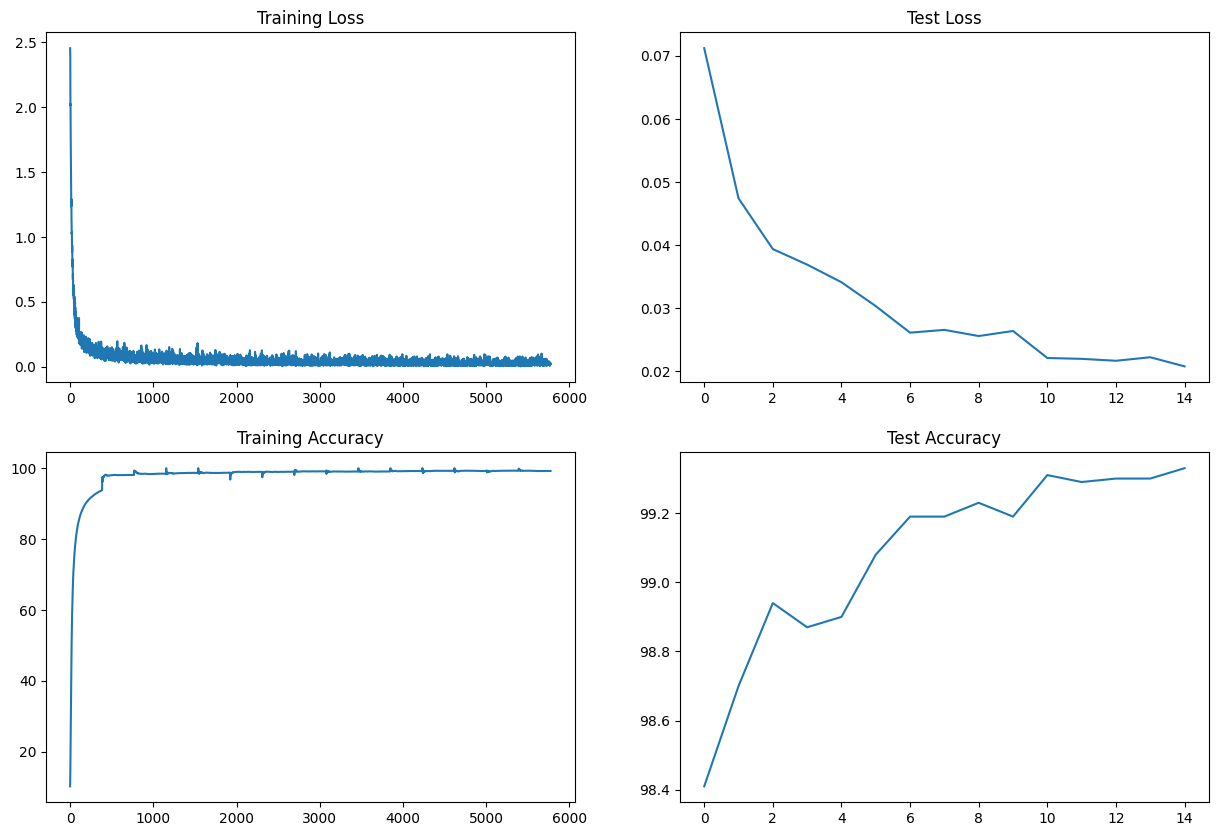

In [16]:
%matplotlib inline
import matplotlib.pyplot as plt

fig, axs = plt.subplots(2,2,figsize=(15,10))
t = [t_items.item() for t_items in train_losses]
axs[0, 0].plot(t)
axs[0, 0].set_title("Training Loss")
axs[1, 0].plot(train_acc)
axs[1, 0].set_title("Training Accuracy")
axs[0, 1].plot(test_losses)
axs[0, 1].set_title("Test Loss")
axs[1, 1].plot(test_acc)
axs[1, 1].set_title("Test Accuracy")

**Target:**

Increase model capacity. Add more layers

**Results:**

Parameters: 7.3k

Best Train Accuracy: 99.27

Best Test Accuracy: 99.33

**Analysis:**

Model is not overfitting

We can add image augmentation techniques to further improvise test accuracy